In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchmetrics.functional.regression import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)


In [2]:
filename = "../DATA/oil_price.csv"
priceDF = pd.read_csv(filename, encoding="utf-8", parse_dates=["date"])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10329 entries, 0 to 10328
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    10329 non-null  datetime64[ns]
 1   price   10329 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 161.5 KB


In [3]:
class OilPriceDataset(Dataset):
    def __init__(self, data, min_data=None, max_data=None, step=365):
        data = data if isinstance(data, np.ndarray) else data.values
        self.min_data = np.min(data) if min_data is None else min_data
        self.max_data = np.max(data) if max_data is None else max_data
        self.data = (data - self.min_data) / (self.max_data - self.min_data)
        self.data = torch.FloatTensor(self.data)
        self.step = step

    def __len__(self):
        return len(self.data) - self.step

    def __getitem__(self, i):
        data = self.data[i : i + self.step]
        label = self.data[i + self.step].squeeze()
        return data, label


In [4]:
class OilPriceModel(nn.Module):
    def __init__(self, hidden_size, num_layers, step):
        super().__init__()
        self.rnn = nn.GRU(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc1 = nn.Linear(in_features=hidden_size * step, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=1)

    def forward(self, x):
        x, _ = self.rnn(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return torch.flatten(x)


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
step = 1825
min_data = np.min(priceDF["price"].values)
max_data = np.max(priceDF["price"].values)
dataset = OilPriceDataset(
    priceDF[["price"]], min_data=min_data, max_data=max_data, step=step
)


In [51]:
start_date = priceDF["date"].max() + pd.DateOffset(days=1)
# end_date = priceDF["date"].max() + pd.DateOffset(days=1825)
end_date = pd.to_datetime("2030-12-31")
full_date_range = pd.date_range(start=start_date, end=end_date)
pred_days = len(full_date_range)


In [52]:
preds = []  # 예측값들을 저장하는 리스트
pred_model = torch.load(f"oil_price_model_{step}_cuda.pth", map_location=device)
pred_model.eval()
start = dataset[len(dataset.data[step:]) - 1][0]
with torch.no_grad():
    for i in range(pred_days):
        pred = pred_model(start.unsqueeze(0).to(device))
        start = torch.cat((start[1:].to(device), pred.unsqueeze(0)))
        preds.append(pred.item())


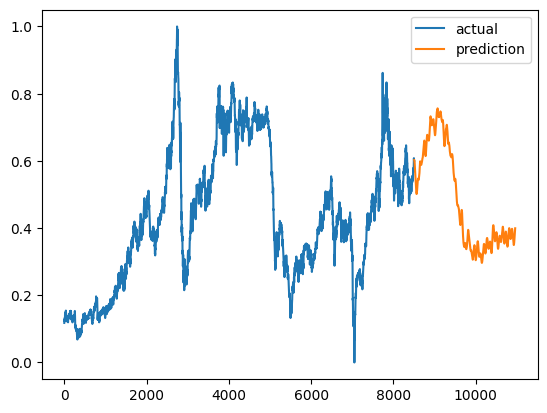

In [53]:
x_1 = np.arange(len(dataset.data[step:]))
x_2 = np.arange(len(preds)) + len(dataset.data[step:])
plt.plot(x_1, dataset.data[step:], label="actual")
plt.plot(x_2, preds, label="prediction")
plt.legend()
plt.show()


In [54]:
real_preds = [x * (float(max_data) - float(min_data)) + float(min_data) for x in preds]
real_preds


[89.19033596754075,
 89.15710562229157,
 89.12209479093552,
 89.06149351835252,
 88.97203218460083,
 88.86449082374574,
 88.73744504690171,
 88.60405426502228,
 88.47775305509568,
 88.33351749420167,
 88.16454936265946,
 87.96552338838578,
 87.72374956130982,
 87.44282122612,
 87.13520178556443,
 86.80042183876039,
 86.44799889326096,
 86.08288593769075,
 85.72112353324891,
 85.3821351647377,
 85.07751017808914,
 84.78840779304505,
 84.49037060499192,
 84.17948154449464,
 83.85815236091615,
 83.52620500564576,
 83.18676342248918,
 82.85378014802933,
 82.53701548337936,
 82.22148906588555,
 81.911093685627,
 81.61909396409989,
 81.36170041799546,
 81.13389531373979,
 80.93977376937868,
 80.75958857536317,
 80.56976447701454,
 80.34671003341676,
 80.08355418682099,
 79.8056688642502,
 79.51676071405412,
 79.21870733976365,
 78.90416018962861,
 78.58579308748246,
 78.25053564667702,
 77.90777588486672,
 77.57403995037079,
 77.26099812030793,
 76.97226801872254,
 76.70417536973954,
 76.458

In [55]:
testDF = pd.DataFrame({"date": full_date_range, "price": real_preds})
testDF["price"] = testDF["price"].round(3)
testDF


,date,price
0,2024-04-13,89.190
1,2024-04-14,89.157
2,2024-04-15,89.122
3,2024-04-16,89.061
4,2024-04-17,88.972
...,...,...
2449,2030-12-27,60.871
2450,2030-12-28,61.085
2451,2030-12-29,61.283
2452,2030-12-30,61.464


In [56]:
pred_priceDF = pd.concat([priceDF, testDF]).reset_index(drop=True)
pred_priceDF


,date,price
0,1996-01-02,17.640
1,1996-01-03,17.650
2,1996-01-04,17.845
3,1996-01-05,18.120
4,1996-01-06,18.165
...,...,...
12778,2030-12-27,60.871
12779,2030-12-28,61.085
12780,2030-12-29,61.283
12781,2030-12-30,61.464


In [57]:
pred_priceDF.to_pickle("pred_priceDF.pkl")


In [69]:
testDF.to_csv(
    f"pred_oil_price_{end_date.strftime('%Y-%m-%d')}.csv", index=False, encoding="utf-8"
)


In [73]:
type((pd.to_datetime("2024-04-13") - pd.to_datetime("2024-04-12")).days)


int